# CS-UY 3943 - Introduction of Data Science
## Week 7: Classification I

Please edit the cell below to add your name, NetID, assigned group, and group members for this assignment. **Complete this section before proceeding to the assignment questions.**

Name:  Lenny Remache
NetID:  ljr381
Group (Letter): C 
Group Member 1:  Yashar Nasir
Group Member 2:  Mateo Garcia
***

In this assignment we will be looking at data generated by particle physicists to test whether machine learning can help classify whether certain particle decay experiments identify the presence of a Higgs Boson. One does not need to know anything about particle physics to do well here, but if you are curious, full feature and data descriptions can be found here:

- https://www.kaggle.com/c/higgs-boson/data
- http://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf

The goal of today's assignment is to access and clean the data to prepare it for use in classification models. Then you will use two classification models with untuned parameters to compare how well each is able to classify the samples.

### Part 1: Data preparation
Create a data preparation and cleaning function that does the following:
- Accepts the name of a text file (a Python `str`) as its single parameter
- Reads in the data from the file (the data is comma separated, has a header row, and the first column `EventId` is the index) into a pandas `DataFrame`
- Cleans the data
  - Convert the column `Label` to a numeric type
    - Assume the `Label` column only has two possible values (`s` or `b`). `b` stands for "background" and `s` stands for "signal". The samples that represent a signal are those which we are most interested in identifying.
    - Create a new column, `Y`, with a **numeric** version of the label. Map samples with `s` as the `Label` value to be equal to `1` and samples with `b` as the `Label` value to be equal to `0`. `Y` will be used as the target value for this dataset.
    - Drop the `Label` column.
  - If a feature of the dataset has missing values (`-999` used for this data set): 
    - Create a dummy column representing the missingness of the feature:
      - Name the column `orig_var_name` + `_mv` where `orig_var_name` is the name of the actual feature with missing values
      - Give this new column a value of `1` if the original value for the feature is missing (`0` otherwise)
      - **Note**: These dummy columns are only needed for certain approaches to replacing missing values in the next step, therefore, you may not need to utilize these values for your solution
    - Replace the missing values with the average of the feature. **Hint**: make sure to compute the mean only using samples where the value isn't missing. You may find pandas' `.replace()` function useful though there are multiple ways to properly perform this calculation.
- After cleaning the data, rescales the data so that each **feature** has a mean of `0` and standard deviation of `1`. While there are classes/functions that can perform rescaling of data directly without the need to code the calculations manually, for this assignment **do this rescaling using only methods available in `pandas`/`numpy`**. This type of scaling can be accomplished by: 
    1. subtracting the mean of the column from each of the values in the column
    1. dividing the resulting values by the standard deviation of the column
- Returns the cleaned and rescaled dataset
    - Make sure any dummy columns that are created are not part of the `DataFrame` that is returned
    
Note: This function can be implemented in less than 15 lines of code.

In [1]:
import pandas as pd
import numpy as np

In [2]:
def clean_boson_data(infile_name):
    
    df = pd.read_csv(infile_name, na_values = -999) # read in data set
    df.set_index(df['EventId']) # set index to EventId column
    numeric = {'Label':{'s': 1,'b': 0}} # used to replace categorical with numeric values
    df_label = df.replace(numeric)
    df['Y'] = df_label['Label'] # new numeric column Y for Label
    df = df.drop('Label', axis=1) # drop original Label column
    
    mean = {'DER_mass_MMC': { float('NaN') : np.nanmean(df['DER_mass_MMC']) },
            'DER_deltaeta_jet_jet': { float('NaN') : np.nanmean(df['DER_deltaeta_jet_jet']) },
            'DER_mass_jet_jet': { float('NaN') : np.nanmean(df['DER_mass_jet_jet']) },
            'DER_prodeta_jet_jet': { float('NaN') : np.nanmean(df['DER_prodeta_jet_jet']) }
           }
    df= df.replace(mean)
    
    columns = df.columns[1:-1]
    
    for column in columns:
        df[column] = (df[column] - np.mean(df[column])) / np.std(df[column])
        
    return df

In [3]:
clean_boson_data('boson_training_cut.csv').head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,Y
0,100000,3.983624e-01,0.092601,0.491173,-0.444021,-1.650125e+00,-1.135322e+00,1.873193e+00,0.888048,1.120050,1
1,100001,8.633960e-01,0.608117,0.639363,-0.120744,-1.941583e-14,1.727761e-14,-4.734354e-15,1.421917,-0.806390,0
2,100002,-1.706033e-14,3.421843,1.261884,-0.321306,-1.941583e-14,1.727761e-14,-4.734354e-15,0.997693,-0.455521,0
3,100003,5.108589e-01,0.989159,0.028516,-0.885926,-1.941583e-14,1.727761e-14,-4.734354e-15,1.209152,-0.886831,0
4,100004,1.172363e+00,-0.953916,1.504447,-0.629578,-1.941583e-14,1.727761e-14,-4.734354e-15,1.967534,-0.113790,0


### Part 2: Basic evaluations
In this part, you will build an out-of-the box logistic regression (LR) model and support vector machine (SVM). Out-of-the-box means that you build models without parameter tuning. You will then plot ROC curves for the LR and SVM model.

1\. Clean the two data files for this assignment (`boson_training_cut.csv` and `boson_testing_cut.csv`) and use them as training and testing data sets, respectively. Two `DataFrame` objects representing cleaned versions of the data will be created in this step.

In [9]:
training_set = clean_boson_data('boson_training_cut.csv')
test_set = clean_boson_data('boson_testing_cut.csv')

print(training_set)

      EventId  DER_mass_MMC  DER_mass_transverse_met_lep  DER_mass_vis  \
0      100000  3.983624e-01                     0.092601      0.491173   
1      100001  8.633960e-01                     0.608117      0.639363   
2      100002 -1.706033e-14                     3.421843      1.261884   
3      100003  5.108589e-01                     0.989159      0.028516   
4      100004  1.172363e+00                    -0.953916      1.504447   
...       ...           ...                          ...           ...   
1994   101994 -4.169521e-01                     0.284974     -0.315544   
1995   101995 -8.979135e-02                    -0.623212     -0.025055   
1996   101996 -1.313012e+00                     0.091245     -0.994622   
1997   101997  1.843533e+00                     0.735452      2.252332   
1998   101998  3.748075e-01                    -1.217865     -0.084325   

      DER_pt_h  DER_deltaeta_jet_jet  DER_mass_jet_jet  DER_prodeta_jet_jet  \
0    -0.444021         -1.650125

2\. On the training set, build the following out-of-the-box (untuned) models:

- A logistic regression using sklearn's `linear_model.LogisticRegression()`. For this model, set `C = 1e30`.
- A Support Vector Machine (SVM) using sklearn's `svm.SVC()`. For this model, use `kernel = "linear"`.

For each model
1. Predict the labels for the test data. Using the predicted labels,
    * output the number of samples assigned `1`
        * by the Logistic Regression model 
        * by the SVM model 
        * as indicated in the test dataset
    * output the number of samples assigned `0` 
        * by the Logistic Regression model 
        * by the SVM model 
        * as indicated in the test dataset
2. Calculate the accuracy for each classifier
    * each classifier's `.score` method can provide this value
3. Plot the accuracy of each classifer on the same bar plot
    * the bar plot will have two bars of different colors representing the accuracy of each classifier
    * include a legend indicating which classifier each bar represents
    * don't forget to provide a title and label your axes (where necessary)

**Make sure to use the test dataset for predicting and calculating the accuracy score**. 

In [5]:
from sklearn import svm, linear_model
%matplotlib inline
import matplotlib.pyplot as plt

X_test = test_set.iloc[:,1:-1]
y_test = test_set['Y']

y_train = training_set['Y']
X_train = training_set.iloc[:,1:-1]


In [6]:
#logistic regression
logreg = linear_model.LogisticRegression(C = 1e30)
logreg.fit(X_train,y_train)
y_pred_logreg = logreg.predict(X_test)

isZero_logreg = 0
isOne_logreg = 0
for pred in y_pred_logreg:
    if pred == 0:
        isZero_logreg += 1
    else:
        isOne_logreg += 1

logreg_accuracy = logreg.score(X_test,y_test)
print('Logistic Regression')
print('Prediction of 0: {}'.format(isZero_logreg))
print('Prediction of 1: {}'.format(isOne_logreg)) 
print('Accuracy: {}'.format(logreg_accuracy))

Logistic Regression
Prediction of 0: 39744
Prediction of 1: 10256
Accuracy: 0.72078


In [7]:
svm_part = svm.SVC(kernel='linear')
svm_part.fit(X_train,y_train)
y_pred_svm = svm_part.predict(X_test)

isZero_svm = 0
isOne_svm = 0
for pred in y_pred_svm:
    if pred == 0:
        isZero_svm += 1
    else:
        isOne_svm += 1

svm_accuracy = svm_part.score(X_test,y_test)
print('SVM')
print('Prediction of 0: {}'.format(isZero_svm))
print('Prediction of 1: {}'.format(isOne_svm)) 
print('Accuracy: {}'.format(svm_accuracy))

SVM
Prediction of 0: 45183
Prediction of 1: 4817
Accuracy: 0.6984


<BarContainer object of 1 artists>

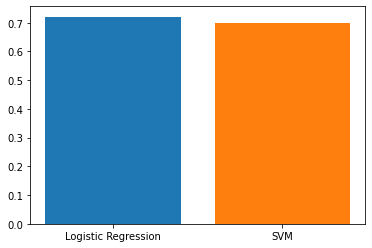

In [8]:
plt.bar('Logistic Regression',logreg_accuracy)
plt.bar('SVM',svm_accuracy)